In [ ]:
# Libraries
using ScikitLearn;
using DataFrames;
using CSV;
using Random;
using Statistics;
using StatsPlots;
using Flux.Losses;
using Flux;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import feature_selection: SelectKBest; # Feature Selection
@sk_import feature_selection: f_classif; # Used with SelectKBest
@sk_import svm: SVC;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculation and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology

# Set seed
Random.seed!(10);

LoadError: LoadError: ArgumentError: Package Flux not found in current path.
- Run `import Pkg; Pkg.add("Flux")` to install the Flux package.
in expression starting at c:\Users\Alogon\Documents\GitHub\projectA_ML1\utils\fluxANNs.jl:1

In [ ]:
using Pkg;

Pkg.add("Flux")

   Resolving package versions...
   Installed UnsafeAtomicsLLVM ─ v0.2.2
   Installed MLDataDevices ───── v1.5.3
   Installed Optimisers ──────── v0.3.4
   Installed OneHotArrays ────── v0.2.6
   Installed Zygote ──────────── v0.6.73
   Installed GPUArrays ───────── v11.1.0
   Installed NNlib ───────────── v0.9.26
   Installed ChainRules ──────── v1.72.1
   Installed GPUArraysCore ───── v0.2.0
   Installed ArgCheck ────────── v2.4.0
   Installed StructArrays ────── v0.6.21
   Installed ForwardDiff ─────── v0.10.38
   Installed Flux ────────────── v0.14.25
    Updating `C:\Users\Alogon\.julia\environments\v1.11\Project.toml`
  [587475ba] + Flux v0.14.25
    Updating `C:\Users\Alogon\.julia\environments\v1.11\Manifest.toml`
  [7d9f7c33] + Accessors v0.1.38
  [dce04be8] + ArgCheck v2.4.0
⌅ [a9b6321e] + Atomix v0.1.0
  [198e06fe] + BangBang v0.4.3
  [9718e550] + Baselet v0.1.1
  [fa961155] + CEnum v0.5.0
  [082447d4] + ChainRules v1.72.1
⌅ [3da002f7] ↓ ColorTypes v0.12.0 ⇒ v0.11.5
⌃ [c3611

# Hold-out partition

In [ ]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');
support2[:, "hospdeath"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "hospdeath"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);
trainTargets = convert(Array{Bool,1}, Array(support2[trainIndex, "death"]));
testTargets = convert(Array{Bool,1}, Array(support2[testIndex, "death"]));
trainTargets = convert(Array{Bool,1}, Array(support2[trainIndex, "death"]));
testTargets = convert(Array{Bool,1}, Array(support2[testIndex, "death"]));

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

# Imputation

In [ ]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Binary approach

- ANN

In [ ]:
ANNparams2 = [Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams2)];
bestMetricYet = 0;
bestModel = -1;

for (modelType, paramList) in models
    cnt = 1;
    println("Training ", modelType, " models:");
    for params in paramList
        (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                      trainTargets, kFoldIndices);
        println("Configuration ", cnt);
        println("Accuracy:", accur, ", stdDev:", stdAccur);
        println("F1-Score:", fScore, ", stdDev:", stdFScore);
        println();
        cnt += 1;
        #println(modelType, (accur, fScore), (stdAccur, stdFScore))
        if accur * fScore > bestMetricYet
            bestMetricYet = accur * fScore;
            bestModel = (modelType, params);
        end;
    end;
end;

(modelType, params) = bestModel;
println("Best model is ", modelType, " with hyperparameters:");
println(params);

- SVM

In [ ]:
SVMparams = [Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "rbf", "degree" => 3, "gamma" => 30, "C" => 1), # higher gamma
            Dict("kernel" => "sigmoid", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => 2, "C" => 1),
            Dict("kernel" => "poly", "degree" => 6, "gamma" => 2, "C" => 1)] # higher degree

models = [(:ANN, SVMparams)];
bestMetricYet = 0;
bestModel = -1;

for (modelType, paramList) in models
    cnt = 1;
    println("Training ", modelType, " models:");
    for params in paramList
        (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                      trainTargets, kFoldIndices);
        println("Configuration ", cnt);
        println("Accuracy:", accur, ", stdDev:", stdAccur);
        println("F1-Score:", fScore, ", stdDev:", stdFScore);
        println();
        cnt += 1;
        #println(modelType, (accur, fScore), (stdAccur, stdFScore))
        if accur * fScore > bestMetricYet
            bestMetricYet = accur * fScore;
            bestModel = (modelType, params);
        end;
    end;
end;

(modelType, params) = bestModel;
println("Best model is ", modelType, " with hyperparameters:");
println(params);

- DecisionTree

In [ ]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16)]

models = [(:ANN, DTreeParams)];
bestMetricYet = 0;
bestModel = -1;

for (modelType, paramList) in models
    cnt = 1;
    println();
    println("Training ", modelType, " models:");
    for params in paramList
        (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                      trainTargets, kFoldIndices);
        println("Configuration ", cnt);
        println("Accuracy:", accur, ", stdDev:", stdAccur);
        println("F1-Score:", fScore, ", stdDev:", stdFScore);
        println();
        cnt += 1;
        #println(modelType, (accur, fScore), (stdAccur, stdFScore))
        if accur * fScore > bestMetricYet
            bestMetricYet = accur * fScore;
            bestModel = (modelType, params);
        end;
    end;
end;

(modelType, params) = bestModel;
println("Best model is ", modelType, " with hyperparameters:");
println(params);

- KNN

In [ ]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12)]

models = [(:ANN, KNNparams)];
bestMetricYet = 0;
bestModel = -1;

for (modelType, paramList) in models
    cnt = 1;
    println("Training ", modelType, " models:");
    for params in paramList
        (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                      trainTargets, kFoldIndices);
        println("Configuration ", cnt);
        println("Accuracy:", accur, ", stdDev:", stdAccur);
        println("F1-Score:", fScore, ", stdDev:", stdFScore);
        println();
        cnt += 1;
        #println(modelType, (accur, fScore), (stdAccur, stdFScore))
        if accur * fScore > bestMetricYet
            bestMetricYet = accur * fScore;
            bestModel = (modelType, params);
        end;
    end;
end;

(modelType, params) = bestModel;
println("Best model is ", modelType, " with hyperparameters:");

println(params);

In [5]:
# kFoldIndices = crossvalidation(targets, 5)

# # definition of models to train
# models = []

# DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16)]

# KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12)]

# SVMparams = [Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "rbf", "degree" => 3, "gamma" => 30, "C" => 1), # higher gamma
#             Dict("kernel" => "sigmoid", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "poly", "degree" => 3, "gamma" => 2, "C" => 1),
#             Dict("kernel" => "poly", "degree" => 6, "gamma" => 2, "C" => 1)] # higher degree

# ANNparams = [Dict("topology" => [3, 8], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1),
#             Dict("topology" => [6, 16], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1),
#             Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1)]

# ANNparams2 = [Dict("topology" => [12, 32], "maxEpochs" => 1000, "minLoss" => 0., "learningRate" => 0.01, 
#                 "maxEpochsVal" => 20, "validationRatio" => 0.1)]
# #models = [(:KNN, KNNparams),(:DTree, DTreeParams),(:SVM, SVMparams),(:ANN, ANNparams)]
# models = [(:ANN, ANNparams2)]
# bestMetricYet = 0
# bestModel = -1

# for (modelType, paramList) in models
#     cnt = 1
#     println("Training ", modelType, " models:")
#     for params in paramList
#         (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, inputs, targets, kFoldIndices)
#         println("Configuration ", cnt)
#         println("Accuracy:", accur, ", stdDev:", stdAccur)
#         println("F1-Score:", fScore, ", stdDev:", stdFScore)
#         println()
#         cnt += 1
#         #println(modelType, (accur, fScore), (stdAccur, stdFScore))
#         if accur * fScore > bestMetricYet
#             bestMetricYet = accur * fScore
#             bestModel = (modelType, params)
#         end
#     end
# end

# (modelType, params) = bestModel
# println("Best model is ", modelType, " with hyperparameters:")
# println(params)

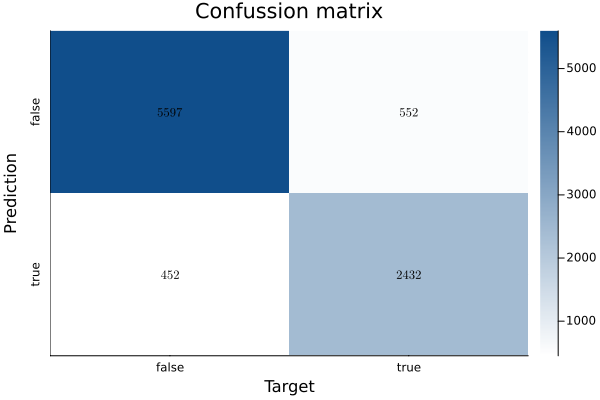

In [ ]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end;
train, val, test = prepareDataForFitting(train, test, valRatio);

classes = unique(trainTargets);
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes);
confMat = matAndMetrics[8];
println(confMat);

# function displayConfMat(confMat, classes)
#     (n,m) = size(confMat);
#     heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
#             title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true);
#     # add number of coincidences in each cell
#     annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m]);
# end;

# displayConfMat(confMat, classes);

# Ensemble training

In [ ]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
modelsEnsemble = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 8)
KNNparams = Dict("k" => 6)
SVMparams = Dict("kernel" => "rbf", "degree" => 3, "gamma" => 2, "C" => 1)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

trainClassEnsemble(modelsEnsemble, params, (trainInputs, reshape(trainTargets, length(trainTargets), 1)),
                   crossvalidation(trainTargets, 5))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7a7e57d6f2e0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

([0.8887434676167014 0.40990231896998586], [0.006747966721490579 0.19243679872447852])